# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 15.03.2020

Мягкий дедлайн: 02:59MSK 30.03.2020

Жесткий дедлайн: 23:59MSK 03.04.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Kitchen Sinks для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
X_train = x_train_pics.reshape(x_train_pics.shape[0],-1)
X_test = x_test_pics.reshape(x_test_pics.shape[0],-1)

Using TensorFlow backend.


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Желательно в виде класса с методами fit() и predict().

Что должно быть в вашей реализации:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy.linalg as LA
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [3]:
class RandomKitchenSinks:
    def __init__(self,
                 new_dim: int = 50,
                 n_features: int = 1000,
                 model_type: str = 'LogisticRegression',
                 decrease_dimension: bool = True,
                 random_state: int = 18):

        self.new_dim = new_dim
        self.n_features = n_features
        self.model_type = model_type
        self.decrease_dim = decrease_dimension
        self.rand_state = random_state
        self._clf = None
        self._pca = None
        self._W = None
        self._b = None

    def fit(self, X: np.array, y: np.array) -> None:
        if self.decrease_dim:
            pca = PCA(n_components=self.new_dim, random_state=self.rand_state)
            pca.fit(X)
            self._pca = pca
        
            X_low = self._is_pca(X)
            sigma = self._get_sigma(X_low)
            self._W, self._b = self._get_weights_and_bias(sigma)
            X_new = np.cos(X_low.dot(self._W.T) + self._b)
        else:
            X_new = X

        if self.model_type == 'LogisticRegression':
            clf = LogisticRegression(tol=1e-2, random_state=self.rand_state)
        elif self.model_type == 'SVC':
            clf = SVC(kernel='rbf', random_state=self.rand_state, gamma='scale')
        elif self.model_type == 'LinearSVC':
            clf = SVC(kernel='linear', random_state=self.rand_state, gamma='scale')
        else:
            raise AttributeError('Implemented only for LogisticRegression, SVC and LinearSVC')

        clf.fit(X_new, y)
        self._clf = clf

    def _get_sigma(self, X: np.array) -> float:
        sample_size = 2000
        np.random.seed(self.rand_state)
        inds = np.random.default_rng(seed=self.rand_state).choice(
            X.shape[0], size=sample_size, replace=False)
        arr = []
        for e, i in enumerate(inds[:-1]):
            for j in inds[e + 1:]:
                arr.append(np.sum(np.square(X[i] - X[j])))

        return np.sqrt(np.median(arr))

    def _get_weights_and_bias(self, sigma):
        W = []
        for i in range(self.n_features):
            np.random.seed(self.rand_state + i)
            W.append(np.random.normal(0, 1/sigma, self.new_dim))
        W = np.array(W)
        np.random.seed(self.rand_state)
        b = np.random.uniform(-np.pi, np.pi, self.n_features)

        return W, b

    def _is_pca(self, X: np.array) -> np.array:
        return self._pca.transform(X) if self.decrease_dim else X.copy()

    def predict(self, X: np.array) -> np.array:
        X_new = self._is_pca(X)
        if self.decrease_dim:
            X_new = np.cos(X_new.dot(self._W.T) + self._b)
        return self.clf.predict(X_new)

    def score(self, X: np.array, y: np.array) -> float:
        X_new = self._is_pca(X)
        if self.decrease_dim:
            X_new = np.cos(X_new.dot(self._W.T) + self._b)
        return self._clf.score(X_new, y)

In [5]:
rks = RandomKitchenSinks()
rks.fit(X_train, y_train)
rks.score(X_test, y_test)

0.8565

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг (используйте нормальную имплементацию, а не из sklearn, и подберите число деревьев и длину шага).

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [4]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from time import time

In [6]:
model_types = ['LinearSVC', 'SVC']

np.random.seed(18)
inds = np.random.choice(
    X_train.shape[0], 10000, replace=False)
X = X_train[inds, :]    
tmp_y = y_train[inds]

for is_decr in [True, False]:
    for model_type in model_types:
        rks = RandomKitchenSinks(
            model_type=model_type, decrease_dimension=is_decr)
        st = time()
        rks.fit(X, tmp_y)
        score = rks.score(X_test, y_test)
        print(f'model_type: {model_type}, with pca: {is_decr}, time: {time() - st}, score: {score}')

model_type: LinearSVC, with pca: True, time: 73.12318277359009, score: 0.8486
model_type: SVC, with pca: True, time: 101.17157363891602, score: 0.8252
model_type: LinearSVC, with pca: False, time: 64.22402238845825, score: 0.7967
model_type: SVC, with pca: False, time: 63.020519495010376, score: 0.8515


In [8]:
pca = PCA(n_components=50, random_state=18)
pca.fit(X_train)
X = pca.transform(X_train)

In [12]:
gridParams = {
    'learning_rate': [0.3, 0.1, 0.01],
    'n_estimators': [100, 250, 500]
}

clf = lgb.LGBMClassifier(n_jobs=30, random_state=18)
grid = GridSearchCV(clf, gridParams, verbose=0, cv=3, n_jobs=3)
grid.fit(X, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.3, 'n_estimators': 400}
0.8832833333333333


In [9]:
best_params_ = {'learning_rate': 0.3, 'n_estimators': 400}
clf = lgb.LGBMClassifier(**best_params_, n_jobs=1)
st = time()
clf.fit(X, y_train)
X_tst = pca.transform(X_test)
pred = clf.predict(X_tst)
print(f'score: {accuracy_score(pred, y_test)}, time: {time() - st}')

score: 0.8807, time: 107.27481460571289


__Вывод:__ Если  сравнивать линейный SVM с ядровым, то почти быстрее всего и лучше всего работает ядровый без понижения размерности, и в целом получается, что обучение на случайных признаках работает хуже. При этом он может обучаться на меньшем количестве данных и показывть результат на уровне. Но если праивльно подобрать гиперпараметры, то результат может быть лучше (все сравнения были с стандартными параматрами).

Если сравнивать метод случайных признаков с градиентным бустингом, то и здесь этот алгоритм показывает качество немного хуже, но при этом вреемени на обучение ему нужно меньше. 

Можно сделать вывод, что если требуется построить модель, которая не требует много памяти и времени для обучения, и при этом если данных много, и нет возможности обучаться на всей выборке, то в таком случае хорошо подходит подход со случайных признаков.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [17]:
for is_decr in [True, False]:
    for model_type in ['LogisticRegression','SVC']:
        if model_type == 'SVC':
            np.random.seed(18)
            inds = np.random.choice(
                X_train.shape[0], 10000, replace=False)
            X = X_train[inds, :]    
            tmp_y = y_train[inds]
        else:
            X = X_train
            tmp_y = y_train
        if is_decr:
            for new_dim in [20, 50, 100, 200]:
                rks = RandomKitchenSinks(
                    model_type=model_type, decrease_dimension=is_decr, new_dim=new_dim)
                st = time()
                rks.fit(X, tmp_y)
                score = rks.score(X_test, y_test)
                print(f'model_type: {model_type}, with pca: {is_decr}, new_dim: {new_dim}, time: {time() - st}, score: {score}')
        else:
            rks = RandomKitchenSinks(
                model_type=model_type, decrease_dimension=is_decr)
            st = time()
            rks.fit(X, tmp_y)
            score = rks.score(X_test, y_test)
            print(f'model_type: {model_type}, with pca: {is_decr}, time: {time() - st}, score: {score}')

model_type: LogisticRegression, with pca: True, new_dim: 20, time: 41.916661739349365, score: 0.841
model_type: LogisticRegression, with pca: True, new_dim: 50, time: 41.99097013473511, score: 0.8565
model_type: LogisticRegression, with pca: True, new_dim: 100, time: 47.55576467514038, score: 0.8649
model_type: LogisticRegression, with pca: True, new_dim: 200, time: 47.65153932571411, score: 0.8659
model_type: SVC, with pca: True, new_dim: 20, time: 98.20271062850952, score: 0.8167
model_type: SVC, with pca: True, new_dim: 50, time: 95.74743103981018, score: 0.8369
model_type: SVC, with pca: True, new_dim: 100, time: 96.71687769889832, score: 0.8423
model_type: SVC, with pca: True, new_dim: 200, time: 100.68157315254211, score: 0.8452
model_type: LogisticRegression, with pca: False, time: 20.448453903198242, score: 0.8412
model_type: SVC, with pca: False, time: 63.57779026031494, score: 0.8515


In [30]:
scores = dict()

for n in [i for i in range(50, 201, 50)]:
    rks = RandomKitchenSinks(n_features=n)
    rks.fit(X_train, y_train)
    scores[n] = rks.score(X_test, y_test)
    
for n in [i for i in range(250, 2501, 250)]:
    rks = RandomKitchenSinks(n_features=n)
    rks.fit(X_train, y_train)
    scores[n] = rks.score(X_test, y_test)

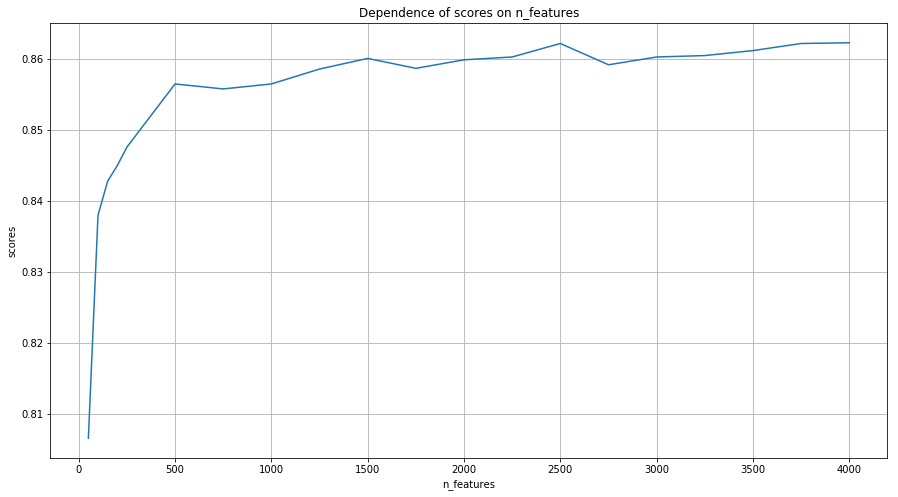

In [41]:
from matplotlib import pylab as plt

plt.figure(figsize=(15, 8))
plt.plot(scores.keys(), scores.values())
plt.grid()
plt.title('Dependence of scores on n_features')
plt.xlabel('n_features')
plt.ylabel('scores');

__Вывод:__
1. Если оптимально подобрать количестов векторов для понижения размерности, то предварительное понижение может помочь, вне зависимсти от выбора линейной модели. Из за того, что PCA выделяет наиболее важные особенности объектов, применение случайности к результатам PCA приводит к хорошим результатам, но в тоже время большое количество не очень осмысленных признаков без применения PCA приводит к ухудшенной эффективности и к сильному замедлению работы модели.
2. Итоговое качество зависит от n_features прямопропорционально, т. е. чем больше делаем признаков, тем лучше качество. Но при этом при росте n_features оно выходит на плато.
3. Видно, что LogisticRegression на случайных призна работает быстрее и лучше, чем ядровый SVM 

### Бонус

Ниже приведены задания на бонусные баллы. За исследования на стандартных датасетах из sklearn или, скажем, на титанике, баллы не будут начисляться. Приветствуются интересные выводы из проведённых экспериментов.

__Задание 4. (Максимум 2 балла)__

Возьмите какой-нибудь достаточно сложный датасет, на котором хорошо работает градиентный бустинг. Сравните бустинг с нашим алгоритмом со случайными признаками с точки зрения качества и скорости. Подберите как следует гиперпараметры алгоритма.

###   [Ссылка на датасет Dota2_Games_Results](https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results)

In [5]:
import json
with open('heroes.json') as json_file:
    data = json.load(json_file)

In [6]:
# 1. Team won the game (1 or -1)
# 2. Cluster ID (related to location)
# 3. Game mode (eg All Pick)
# 4. Game type (eg. Ranked)

cols = ['win', 'cluster_id', 'game_mode', 'game_type', 'other']
for i in data['heroes']:
    cols.append(i['name'])

In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

train = pd.read_csv('dota2Train.csv', names=cols)
test = pd.read_csv('dota2Test.csv', names=cols)
train.loc[train.win == -1, 'win'] = 0
test.loc[test.win == -1, 'win'] = 0
categories=['cluster_id', 'game_mode', 'game_type', 'other']
train.head()

,win,cluster_id,game_mode,game_type,other,antimage,axe,bane,bloodseeker,crystal_maiden,...,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,0,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,0,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
for i in categories:
    train = train.join(pd.get_dummies(train[i], prefix=i))
    del train[i]
    test = test.join(pd.get_dummies(test[i], prefix=i))
    del test[i]

In [9]:
for i in train.columns:
    if i not in test.columns:
        print(i)
        del train[i]

cluster_id_212


In [10]:
X_train, X_test, y_train, y_test = train.drop(columns='win').values, test.drop(columns='win').values, train['win'].values, test['win'].values

In [11]:
X_train.shape, X_test.shape

((92650, 173), (10294, 173))

In [12]:
len(y_train[y_train==1]), len(y_train[y_train==0])

(48782, 43868)

In [13]:
rks = RandomKitchenSinks(new_dim=150, n_features=300)
st = time()
rks.fit(X_train, y_train)
print('score', rks.score(X_test, y_test), 'time:', time() - st)

score 0.5947153681756363 time: 28.36074733734131


In [14]:
gridParams = {
    'learning_rate': [0.3, 0.1, 0.01],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4]
}

pca = PCA(n_components=150, random_state=18)
pca.fit(X_train)
X = pca.transform(X_train)

clf = lgb.LGBMClassifier(n_jobs=30, random_state=18)
grid = GridSearchCV(clf, gridParams, verbose=0, cv=3, n_jobs=3)
grid.fit(X, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.5915704487239015


In [15]:
clf = lgb.LGBMClassifier(**grid.best_params_, n_jobs=1)
st = time()
clf.fit(X, y_train)
X_tst = pca.transform(X_test)
pred = clf.predict(X_tst)
print(f'score: {accuracy_score(pred, y_test)}, time: {time() - st}')

score: 0.5912181853506897, time: 17.825340747833252


__Вывод:__ Несмотря на то, что бустинг оказался быстрее, он показал качетсво хуже (может быть нужно было тщательнее подбирать гиперпараметры). Возможно, из за того что не использовал категориальные фичи, а все энкодил (а обычно бустинг больше дружит с категориаьными), то получить очень хорошего качества не удалось.

__Задание 5. (Максимум 2 балла)__

Возьмите какой-нибудь датасет с текстами и решите одним из стандартных методов (например, tf-idf + логистическая регрессия или что-то нейросетевое). Сравните по качеству и скорости с нашим алгоритмом.

[Ссылка на данные](https://www.kaggle.com/c/texts-classification-ml-hse-2019/data)

In [16]:
Train = pd.read_csv('train.csv')

In [17]:
Train.fillna('', inplace=True)
Train['td'] = Train['title'].str[:] + ' ' + Train['description'].str[:]

In [18]:
from gensim import utils
import gensim.parsing.preprocessing as gsp
from nltk.corpus import stopwords
stopWords = stopwords.words('russian')
from sklearn.base import BaseEstimator

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
#     s = [stemmer.stem(word) for word in s]
    return s

In [19]:
np.random.seed(18)
inds = np.random.choice(
    Train.shape[0], 80000, replace=False)
X = Train[Train.index.isin(inds)]
tmp_y = Train['Category'].values[inds]

In [20]:
X = X.reset_index(drop=True)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):
    def __init__(self):
        self._model = TfidfVectorizer(stop_words=stopWords,  min_df=10, max_df=0.8)

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [22]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_transformer.fit(X['td'])

Text2TfIdfTransformer()

In [23]:
tfidf_X = tfidf_transformer.transform(X['td'])

In [24]:
tfidf_X.shape

(80000, 22907)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_X, tmp_y, test_size=0.1, random_state=18)

In [27]:
clf = LogisticRegression()
st = time()
clf.fit(X_train, y_train)
clf.score(X_test, y_test), time() - st

(0.17175, 276.0195503234863)

In [29]:
rks = RandomKitchenSinks(new_dim=250, n_features=1000)
st = time()
rks.fit(X_train.toarray(), y_train)
print('score', rks.score(X_test.toarray(), y_test), 'time:', time() - st)

score 0.172875 time: 209.44366478919983


__Вывод:__ Датасет оказался не очень
Тем не менее наш метод на нем показал лучшую скорость и время

__Задание 6. (Максимум 2 балла)__

Поэкспериментируйте на нескольких датасетах из прошлых пунктов с фукнциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества.